### Financial Engineering 1: Hedging Assignment

In [36]:
# imports
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pyfinance.options import BSM

from scipy.stats import norm

In [37]:
# import data and print head to get rough idea of what is contained
data = pd.read_csv('./msftOct.csv')
data.head()

,Unnamed: 0,Date,Underlying,C300,C305,C310,C315,C320,C325,C330,...,P350,P355,P360,P365,P370,P375,P380,P385,P390,P395
0,0,2023-07-24,345.11,51.45,47.21,44.16,39.30,36.10,32.00,28.35,...,19.10,21.85,25.00,28.62,31.15,35.45,40.00,NaN,47.92,51.85
1,1,2023-07-25,350.98,57.00,52.44,48.78,44.72,41.00,36.76,32.91,...,16.21,18.95,21.45,24.41,28.25,31.20,37.45,NaN,NaN,50.06
2,2,2023-07-26,337.77,44.56,38.95,36.57,29.91,28.35,25.24,22.15,...,21.00,24.24,27.72,31.22,32.70,38.95,46.45,NaN,NaN,NaN
3,3,2023-07-27,330.72,40.00,34.05,30.42,27.76,23.80,20.55,18.18,...,26.20,29.54,28.95,36.20,NaN,NaN,NaN,NaN,56.38,NaN
4,4,2023-07-28,338.37,45.50,40.22,37.57,33.31,29.50,25.70,22.33,...,19.95,23.19,26.30,30.20,NaN,NaN,NaN,NaN,NaN,NaN


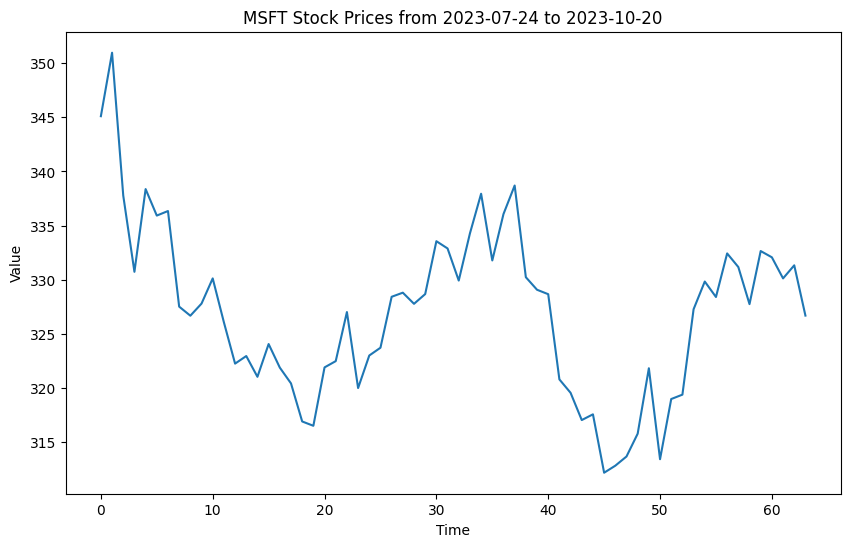

In [38]:
# display underlying stock prices in a chart
fig = plt.figure(figsize=(10,6))
plt.plot(data.index, data['Underlying'])
plt.title(f'MSFT Stock Prices from {data["Date"].min()} to {data["Date"].max()}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [39]:
def prepare_data(csvfilepath):
    # read in data
    data = pd.read_csv(csvfilepath)

    # add time to maturity as a column
    maturity = pd.to_datetime(data['Date'].max())
    data['T'] = maturity - pd.to_datetime(data['Date'])
    data['T'] = data['T'].dt.days

    # Add r column (interest rate) - for the moment arbitrary fixed
    data['r'] = 0.05

    # separate data for call and put options
    common_cols = ['Date', 'Underlying', 'T', 'r']
    data_call = data[common_cols + [col for col in data.columns if col.startswith('C')]]
    data_put = data[common_cols + [col for col in data.columns if col.startswith('P')]]

    # melt strike prices into one column for call
    # first remane columns to be a float value
    columnsC_to_transform = [col for col in data_call.columns if col.startswith('C')]
    new_column_namesC = {col: float(col[1:]) for col in columnsC_to_transform}
    data_call.rename(columns=new_column_namesC, inplace=True)
    # Now we can use melt function so that the strike price becomes a variable
    data_call = data_call.melt(id_vars=['Underlying', 'Date', 'T', 'r'], var_name="E").dropna()
    # We rename the Call option price to Cobs
    data_call.rename({'value':'Cobs'}, axis='columns', inplace=True)


    # melt strike prices into one column for put
    # first rename columns to be a float value
    columnsP_to_transform = [col for col in data_put.columns if col.startswith('P')]
    new_column_namesP = {col: float(col[1:]) for col in columnsP_to_transform}
    data_put.rename(columns=new_column_namesP, inplace=True)
    # Melt function for data_put 
    data_put = data_put.melt(id_vars=['Underlying', 'Date', 'T', 'r'], var_name="E").dropna()
    # We rename the Put option price to Pobs
    data_put.rename({'value':'Pobs'}, axis='columns', inplace=True)

    # # Scaling variables of data_call
    data_call['r'] = data_call['r'] / 100
    data_call['T'] = data_call['T'] / 252
    data_call['Underlying'] = data_call['Underlying'] / 1000
    data_call['E'] = data_call['E'] / 1000
    data_call['Cobs'] = data_call['Cobs'] / 1000
    # volatility call
    data_call['volatility'] = data_call.apply(lambda row:  BSM(kind='call', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=0.1).implied_vol(value = row['Cobs']) if row['T'] != 0 else np.nan, axis = 1)

    # Scaling variables of data_put
    data_put['r'] = data_put['r'] / 100
    data_put['T'] = data_put['T'] / 252
    data_put['Underlying'] = data_put['Underlying'] / 1000
    data_put['E'] = data_put['E'] / 1000
    data_put['Pobs'] = data_put['Pobs'] / 1000
    # volatility put
    data_put['volatility'] = data_put.apply(lambda row:  BSM(kind='put', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=0.1).implied_vol(value = row['Pobs']) if row['T'] != 0 else np.nan, axis = 1)

    # Filtering unwanted volatilities, i.e. volatility smaller than zero and larger than 0.6
    data_call = data_call[(data_call['volatility'] < 0.6) & (data_call['volatility'] > 0.0)]
    data_put = data_put[(data_put['volatility'] < 0.6) & (data_put['volatility'] > 0.0)]

    # Adding new column Delta, Vega and Gamma to data_call
    data_call['Delta'] = data_call.apply(lambda row:  BSM(kind='call', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).delta(), axis = 1)
    data_call['Vega'] = data_call.apply(lambda row:  BSM(kind='call', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).vega(), axis = 1)
    data_call['Gamma'] = data_call.apply(lambda row:  BSM(kind='call', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).gamma(), axis = 1)

    # Adding new column Delta, Vega and Gamma to data_put
    data_put['Delta'] = data_put.apply(lambda row:  BSM(kind='put', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).delta(), axis = 1)
    data_put['Vega'] = data_put.apply(lambda row:  BSM(kind='put', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).vega(), axis = 1)
    data_put['Gamma'] = data_put.apply(lambda row:  BSM(kind='put', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).gamma(), axis = 1)

    return data_call, data_put

def get_option_portfolio_values(portfolio, start_date, end_date, all_options, call_options, put_options):
    portfolio_values = {date: np.NaN for date in all_options.loc[(all_options['Date'] >= start_date) & (all_options['Date'] <= end_date), 'Date']}

    for option, quantity, buy_sell in portfolio:
        option_type = option[0]
        option_strike = float(option[1:])

        if(option_type == 'C'):
            options_data = call_options
            option_price_column = 'Cobs'
        else:
            options_data = put_options
            option_price_column = 'Pobs'

        for index, row in options_data[(options_data['Date'] >= start_date) & (options_data['Date'] <= end_date) & (options_data['E'] == (option_strike/1000))].iterrows():              
            if (np.isnan(portfolio_values[row['Date']])):
                portfolio_values[row['Date']] = 0
            
            if buy_sell == 'buy':
                portfolio_values[row['Date']] += (row[option_price_column] * quantity)
            else:
                portfolio_values[row['Date']] -= (row[option_price_column] * quantity)

    sorted_portfolio_values = dict(sorted(portfolio_values.items()))
                
    return np.array(list(sorted_portfolio_values.values()))

def get_values(ticker, start_date, end_date, all_options, call_options, put_options):
    values = {date: np.NaN for date in all_options.loc[(all_options['Date'] >= start_date) & (all_options['Date'] <= end_date), 'Date']}

    options_data = all_options

    if(ticker == 'Underlying'):
        for index, row in options_data[(options_data['Date'] >= start_date) & (options_data['Date'] <= end_date)].iterrows():
            values[row['Date']] = row['Underlying']
        sorted_values = dict(sorted(values.items()))
        return np.array(list(sorted_values.values()))

    if(ticker[0] == 'C'):
        options_data = call_options
        option_price_column = 'Cobs'
    elif(ticker[0] == 'P'):
        options_data = put_options
        option_price_column = 'Pobs'

    option_strike = float(ticker[1:])

    for index, row in options_data[(options_data['Date'] >= start_date) & (options_data['Date'] <= end_date) & (options_data['E'] == (option_strike/1000))].iterrows():       
        values[row['Date']] = row[option_price_column]

    sorted_values = dict(sorted(values.items()))
        
    return np.array(list(sorted_values.values()))

def get_delta_values(portfolio, start_date, end_date, all_options, call_options, put_options):
    delta_values = {date: np.NaN for date in all_options.loc[(all_options['Date'] >= start_date) & (all_options['Date'] <= end_date), 'Date']}

    for option, quantity, buy_sell in portfolio:
        option_type = option[0]
        option_strike = float(option[1:])

        if(option_type == 'C'):
            options_data = call_options
        else:
            options_data = put_options

        for index, row in options_data[(options_data['Date'] >= start_date) & (options_data['Date'] <= end_date) & (options_data['E'] == (option_strike/1000))].iterrows():         
            if (np.isnan(delta_values[row['Date']])):
                delta_values[row['Date']] = 0
            
            if buy_sell == 'buy':
                delta_values[row['Date']] += (row['Delta'] * quantity)
            else:
                delta_values[row['Date']] -= (row['Delta'] * quantity)

    sorted_delta_values = dict(sorted(delta_values.items()))

    return np.array(list(sorted_delta_values.values()))

def get_vega_values(portfolio, start_date, end_date, all_options, call_options, put_options):
    vega_values = {date: np.NaN for date in all_options.loc[(all_options['Date'] >= start_date) & (all_options['Date'] <= end_date), 'Date']}

    for option, quantity, buy_sell in portfolio:
        option_type = option[0]
        option_strike = float(option[1:])

        if(option_type == 'C'):
            options_data = call_options
        else:
            options_data = put_options

        for index, row in options_data[(options_data['Date'] >= start_date) & (options_data['Date'] <= end_date) & (options_data['E'] == (option_strike/1000))].iterrows():
            if np.isnan(row['Vega']):
                vega_values[row['Date']] = np.NaN
            
            if (np.isnan(vega_values[row['Date']])):
                vega_values[row['Date']] = 0
            
            if buy_sell == 'buy':
                vega_values[row['Date']] += (row['Vega'] * quantity)
            else:
                vega_values[row['Date']] -= (row['Vega'] * quantity)

    sorted_vega_values = dict(sorted(vega_values.items()))

    return np.array(list(sorted_vega_values.values()))

def delta_hedge(hedging_frequency, portfolio_values, underlying_values, delta_values):
    if hedging_frequency <= 0 or hedging_frequency >= len(delta_values):
        return False
    
    start_idx = 0
    portfolio_value = portfolio_values[0]
    underlying_value = underlying_values[0]
    delta = delta_values[0]
    while start_idx < len(delta_values) - 1 and (np.isnan(portfolio_value) or np.isnan(underlying_value) or np.isnan(delta)):
        start_idx += 1
        portfolio_value = portfolio_values[start_idx]
        underlying_value = underlying_values[start_idx]
        delta = delta_values[start_idx]
    
    accuracies = []

    transaction_cost = 0

    missing_data = 0

    for i in range(start_idx + hedging_frequency, len(delta_values), hedging_frequency):
        if(not(np.isnan(portfolio_values[i]) or np.isnan(portfolio_value) or np.isnan(underlying_value) or np.isnan(underlying_values[i]) or np.isnan(delta))):
            accuracy = (portfolio_values[i] - portfolio_value) - (underlying_values[i] - underlying_value) * delta
            accuracies.append(accuracy)
            portfolio_value = portfolio_values[i]
            transaction_cost += abs(underlying_values[i] - underlying_value) * 0.05
            underlying_value = underlying_values[i]
            delta = delta_values[i]
        else:
            missing_data += 1

    print(f'{missing_data} missing data were detected during the delta hedging.')

    mean_squared_error = sum([num**2 for num in accuracies]) / len(accuracies)

    return {
        'accuracies': accuracies,
        'mean_squered_error': mean_squared_error,
        'transaction_cost': transaction_cost
    }

def option_portfolio_delta_hedging(portfolio, start_date, end_date, hedging_frequency, all_options, call_options, put_options):
    # portfolio example: [['C250', 2, 'buy'], ['P400', 1, 'sell']]

    portfolio_values = get_option_portfolio_values(portfolio, start_date, end_date, all_options, call_options, put_options)
    underlying_values = get_values('Underlying', start_date, end_date, all_options, call_options, put_options)
    delta_values = get_delta_values(portfolio, start_date, end_date, all_options, call_options, put_options)

    hedging_results = delta_hedge(hedging_frequency, portfolio_values, underlying_values, delta_values)
    return hedging_results

def solve_2_by_2_linear_system(equation_one, equation_two):
    # equations of the form ax + by = c, dx + ey = f
    a, b, c = equation_one
    d, e, f = equation_two

    x = (b * f - e * c) / (b * d - a * e)
    y = (c - a * x) / b

    return (x, y)

def delta_vega_hedge(hedging_frequency, portfolio_values, portfolio_delta_values, portfolio_vega_values, underlying_values,
                        sec_values, sec_delta_values, sec_vega_values):    
    portfolio_value = portfolio_values[0]
    portfolio_delta= portfolio_delta_values[0]
    portfolio_vega = portfolio_vega_values[0]
    underlying_value = underlying_values[0]
    sec_value = sec_values[0]
    sec_delta = sec_delta_values[0]
    sec_vega = sec_vega_values[0]

    start_idx = 0
    while start_idx < len(portfolio_delta_values) - 1 and any(np.isnan(np.array([portfolio_value, underlying_value, sec_value]))):
            start_idx += 1
            portfolio_value = portfolio_values[start_idx]
            portfolio_delta= portfolio_delta_values[start_idx]
            portfolio_vega = portfolio_vega_values[start_idx]
            underlying_value = underlying_values[start_idx]
            sec_value = sec_values[start_idx]
            sec_delta = sec_delta_values[start_idx]
            sec_vega = sec_vega_values[start_idx]

    sec_amount = portfolio_vega / sec_vega
    underylying_amount = portfolio_delta - (sec_amount) * sec_delta

    accuracies = []

    transaction_cost = 0
    missing_data = 0

    for i in range(start_idx + hedging_frequency, len(sec_delta_values), hedging_frequency):
        if(not(np.isnan(portfolio_values[i]) or np.isnan(portfolio_value) or np.isnan(underlying_value) or np.isnan(underlying_values[i]) or 
               np.isnan(sec_values[i]) or np.isnan(sec_value))):
            change_in_portfolio = portfolio_values[i] - portfolio_value
            change_in_replication = underylying_amount * (underlying_values[i] - underlying_value) + sec_amount * (sec_delta_values[i] - sec_value)
            accuracy = change_in_portfolio - change_in_replication
            accuracies.append(accuracy)
            transaction_cost += change_in_replication * 0.05

            portfolio_value = portfolio_values[i]
            portfolio_delta= portfolio_delta_values[i]
            portfolio_vega = portfolio_vega_values[i]
            underlying_value = underlying_values[i]
            sec_value = sec_values[i]
            sec_delta = sec_delta_values[i]
            sec_vega = sec_vega_values[i]
            sec_amount = portfolio_vega / sec_vega
            underylying_amount = portfolio_delta - (sec_amount) * sec_delta
        else:
            missing_data += 1

    print(f'{missing_data} missing data were detected during the delta vega hedging.')
    mean_squared_error = sum([num**2 for num in accuracies]) / len(accuracies)

    return {
        'accuracies': accuracies,
        'mean_squered_error': mean_squared_error,
        'transaction_cost': transaction_cost
    }

def option_portfolio_delta_vega_hedging(portfolio, hedging_security, start_date, end_date, hedging_frequency, all_options, call_options, put_options, sec_call_data):
    # portfolio example: [['C250', 2, 'buy'], ['P400', 1, 'sell']]

    portfolio_values = get_option_portfolio_values(portfolio, start_date, end_date, all_options, call_options, put_options)
    portfolio_delta_values = get_delta_values(portfolio, start_date, end_date, all_options, call_options, put_options)
    portfolio_vega_values = get_vega_values(portfolio, start_date, end_date, all_options, call_options, put_options)
    underlying_values = get_values('Underlying', start_date, end_date, all_options, call_options, put_options)
    sec_one_values = get_values(hedging_security, start_date, end_date, all_options, sec_call_data, put_options)
    sec_one_delta_values = get_delta_values([[hedging_security, 1, 'buy']], start_date, end_date, all_options, sec_call_data, put_options)
    sec_one_vega_values = get_vega_values([[hedging_security, 1, 'buy']], start_date, end_date, all_options, sec_call_data, put_options)
    
    hedging_results = delta_vega_hedge(hedging_frequency, portfolio_values, portfolio_delta_values, portfolio_vega_values, underlying_values, sec_one_values, 
                                            sec_one_delta_values, sec_one_vega_values)
    return hedging_results

In [40]:
data = pd.read_csv('./msftOct.csv')
jan_call_data, jan_put_data = prepare_data('./msftJan.csv')
feb_call_data, feb_put_data = prepare_data('./msftFeb.csv')
mar_call_data, mar_put_data = prepare_data('./msftMar.csv')
apr_call_data, apr_put_data = prepare_data('./msftApr.csv')
may_call_data, may_put_data = prepare_data('./msftMay.csv')
jun_call_data, jun_put_data = prepare_data('./msftJun.csv')
jul_call_data, jul_put_data = prepare_data('./msftJul.csv')
aug_call_data, aug_put_data = prepare_data('./msftAug.csv')
sept_call_data, sept_put_data = prepare_data('./msftSept.csv')
oct_call_data, oct_put_data = prepare_data('./msftOct.csv')
nov_call_data, nov_put_data = prepare_data('./msftNov.csv')

In [41]:
def get_atm_call_price(date, call_options):
    # Find the call option price with delta value that is closest to 0.5 on the start date, to get the ATM option
    filtered_rows = call_options[pd.to_datetime(call_options['Date']) == date]
    atm_call = filtered_rows.loc[(filtered_rows['Delta'] - 0.5).abs().idxmin()]
    strike = atm_call['E']
    return strike*1000

In [42]:
def get_atm_put_price(date, put_options):
    # Find the call option price with delta value that is closest to 0.5 on the start date, to get the ATM option
    filtered_rows = put_options[pd.to_datetime(put_options['Date']) == date]
    atm_call = filtered_rows.loc[(filtered_rows['Delta'] - 0.5).abs().idxmin()]
    strike = atm_call['E']
    return strike*1000

In [43]:
# Impact of changing Hedging frequency on the accuracy of Delta Hedging 
# Fixed variables: Time to maturity = 45 days, ATM call price

def testing_multiple_hedging_frequencies(all_options, call_options, put_options, sec1_call_data):
    mean_errors_delta_hedging = []
    mean_errors_delta_vega_hedging = []
    mean_transaction_cost_delta_hedging = []
    mean_transaction_cost_delta_vega_hedging = []
    # Testing hedging frequency 1 day, 2 days ... 10 days
    iteration_hedging_frequencies = np.arange(1, 11)
    expiration_date = '2023-10-20'
    start_date = all_options.at[all_options[all_options['Date'] == expiration_date].index[0] - 45, 'Date']
    atm_call_price = get_atm_call_price(start_date, call_options)

    for iteration_hedging_frequency in iteration_hedging_frequencies:        
        result_delta_hedging = option_portfolio_delta_hedging([['C'+str(int(atm_call_price)), 1, 'buy']], start_date, expiration_date, iteration_hedging_frequency, all_options, call_options, put_options)
        mean_errors_delta_hedging.append(result_delta_hedging['mean_squered_error'])
        mean_transaction_cost_delta_hedging.append(result_delta_hedging['transaction_cost'])
        result_delta_vega_hedging = option_portfolio_delta_vega_hedging([['C'+str(int(atm_call_price)), 1, 'buy']], 'C'+str(int(atm_call_price)), start_date, expiration_date, iteration_hedging_frequency, all_options, call_options, put_options, sec1_call_data)
        mean_errors_delta_vega_hedging.append(result_delta_vega_hedging['mean_squered_error'])
        mean_transaction_cost_delta_vega_hedging.append(result_delta_vega_hedging['transaction_cost'])

    # Save data to files
    delta_performance_data_multiple_hedging_frequencies = pd.DataFrame({'Hedging Frequency': iteration_hedging_frequencies, 'Mean Squared Error Delta Hedging': mean_errors_delta_hedging})
    delta_vega_performance_data_multiple_hedging_frequencies = pd.DataFrame({'Hedging Frequency': iteration_hedging_frequencies, 'Mean Squared Error Delta-Vega Hedging': mean_errors_delta_vega_hedging})

    delta_performance_data_multiple_hedging_frequencies.to_csv('delta_performance_multiple_hedging_frequencies.csv', index=False)
    delta_vega_performance_data_multiple_hedging_frequencies.to_csv('delta_vega_performance_multiple_hedging_frequencies.csv', index=False)

    # Plotting
    plt.plot(iteration_hedging_frequencies, mean_errors_delta_hedging, marker='o')
    plt.xlabel('Hedging Frequency (Days)')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Hedging Frequency (Delta Hedging)')
    plt.show()

    plt.plot(iteration_hedging_frequencies, mean_errors_delta_vega_hedging, marker='o')
    plt.xlabel('Hedging Frequency (Days)')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Hedging Frequency (Delta Vega Hedging)')
    plt.show()

    plt.plot(iteration_hedging_frequencies, mean_errors_delta_hedging, label='Delta Hedging', marker='o')
    plt.plot(iteration_hedging_frequencies, mean_errors_delta_vega_hedging, label='Delta-Vega Hedging', marker='o')
    plt.xlabel('Hedging Frequency (Days)')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Hedging Frequency (Comparing Delta and Delta-Vega Hedging Strategies)')
    plt.legend()
    plt.show()

    plt.plot(iteration_hedging_frequencies, mean_transaction_cost_delta_hedging, label='Delta Hedging', marker='o')
    plt.plot(iteration_hedging_frequencies, mean_transaction_cost_delta_vega_hedging, label='Delta-Vega Hedging', marker='o')
    plt.xlabel('Hedging Frequency (Days)')
    plt.ylabel('Transaction cost')
    plt.title('Transaction cost vs. Hedging Frequency (Comparing Delta and Delta-Vega Hedging Strategies)')
    plt.legend()
    plt.show()


3 missing data were detected during the delta hedging.
3 missing data were detected during the delta vega hedging.
1 missing data were detected during the delta hedging.
1 missing data were detected during the delta vega hedging.
2 missing data were detected during the delta hedging.
0 missing data were detected during the delta vega hedging.
0 missing data were detected during the delta hedging.
1 missing data were detected during the delta vega hedging.
1 missing data were detected during the delta hedging.
1 missing data were detected during the delta vega hedging.
1 missing data were detected during the delta hedging.
0 missing data were detected during the delta vega hedging.
1 missing data were detected during the delta hedging.
0 missing data were detected during the delta vega hedging.
0 missing data were detected during the delta hedging.
1 missing data were detected during the delta vega hedging.
1 missing data were detected during the delta hedging.
0 missing data were detec

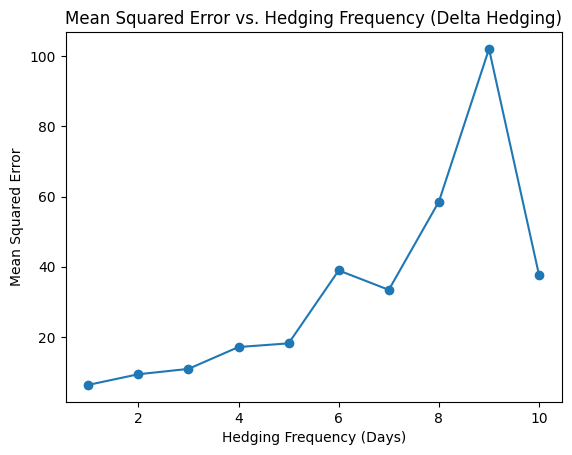

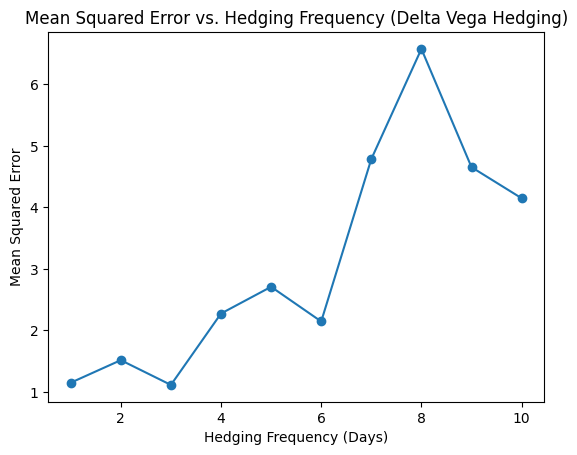

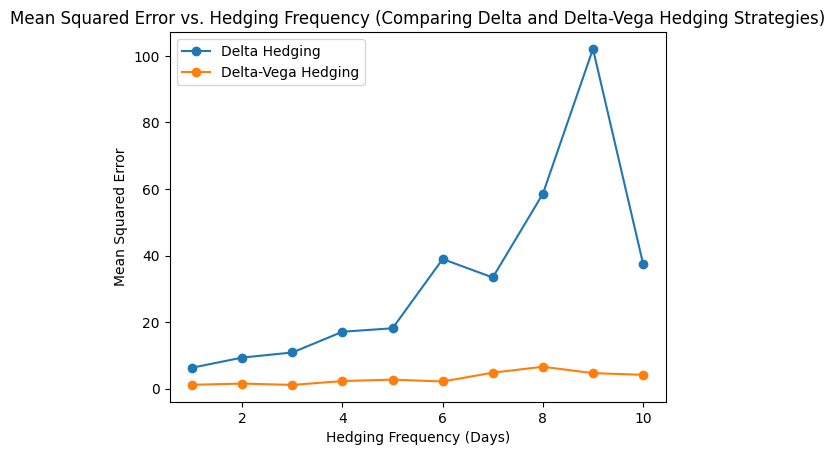

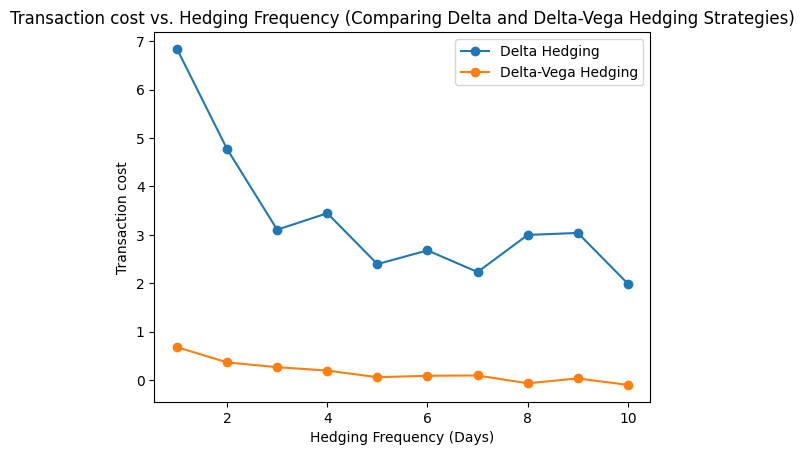

In [44]:
testing_multiple_hedging_frequencies(data, oct_call_data, oct_put_data, nov_call_data)

In [16]:
# Impact of changing time to maturity on the accuracy of Delta Hedging 
# Fixed variables: Hedging every day, ATM call price

def testing_multiple_time_to_maturity(all_options, call_options, put_options, sec1_call_data):
    mean_errors_delta_hedging = []
    mean_errors_delta_vega_hedging = []
    mean_transaction_cost_delta_hedging = [] 
    mean_transaction_cost_delta_vega_hedging = [] 
    # Testing time to maturity 10, 20, ..., 60
    iteration_time_to_maturities = np.arange(10, 31, 5)
    expiration_date = '2023-10-20'
    atm_call_price = get_atm_call_price('2023-10-19', call_options)

    for iteration_time_to_maturity in iteration_time_to_maturities:   
        end_date = pd.to_datetime(expiration_date) - pd.DateOffset(iteration_time_to_maturity)
        hedge_duration = 45
        start_date = end_date - pd.DateOffset(hedge_duration)
        start_date = start_date.strftime('%Y-%m-%d')
        end_date = end_date.strftime('%Y-%m-%d')
        result_delta_hedging = option_portfolio_delta_hedging([['C'+str(int(atm_call_price)), 1, 'buy']], start_date, end_date, 1, all_options, call_options, put_options)
        mean_errors_delta_hedging.append(result_delta_hedging['mean_squered_error'])
        mean_transaction_cost_delta_hedging.append(result_delta_hedging['transaction_cost'])
        result_delta_vega_hedging = option_portfolio_delta_vega_hedging([['C'+str(int(atm_call_price)), 1, 'buy']], 'C'+str(int(atm_call_price)), start_date, end_date, 1, all_options, call_options, put_options, sec1_call_data)
        mean_errors_delta_vega_hedging.append(result_delta_vega_hedging['mean_squered_error'])
        mean_transaction_cost_delta_vega_hedging.append(result_delta_vega_hedging['transaction_cost'])

    # Save data to files
    delta_performance_data_multiple_time_to_maturity = pd.DataFrame({'Time to Maturity': iteration_time_to_maturities, 'Mean Squared Error Delta Hedging': mean_errors_delta_hedging})
    delta_vega_performance_data_multiple_time_to_maturity = pd.DataFrame({'Time to Maturity': iteration_time_to_maturities, 'Mean Squared Error Delta-Vega Hedging': mean_errors_delta_vega_hedging})

    delta_performance_data_multiple_time_to_maturity.to_csv('delta_performance_multiple_time_to_maturity.csv', index=False)
    delta_vega_performance_data_multiple_time_to_maturity.to_csv('delta_vega_performance_multiple_time_to_maturity.csv', index=False)

    # Plotting
    plt.plot(iteration_time_to_maturities, mean_errors_delta_hedging, marker='o')
    plt.xlabel('Time to maturity (Days)')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Time to maturity (Delta Hedging)')
    plt.show()

    plt.plot(iteration_time_to_maturities, mean_errors_delta_hedging, marker='o')
    plt.xlabel('Time to maturity (Days)')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Time to maturity (Delta-Vega Hedging)')
    plt.show()

    plt.plot(iteration_time_to_maturities, mean_errors_delta_hedging, label='Delta Hedging', marker='o')
    plt.plot(iteration_time_to_maturities, mean_errors_delta_vega_hedging, label='Delta-Vega Hedging', marker='o')
    plt.xlabel('Time to Maturity (Days)')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Time to Maturity (Comparing Delta and Delta-Vega Hedging Strategies)')
    plt.legend()
    plt.show()

    plt.plot(iteration_time_to_maturities, mean_transaction_cost_delta_hedging, label='Delta Hedging', marker='o')
    plt.plot(iteration_time_to_maturities, mean_transaction_cost_delta_vega_hedging, label='Delta-Vega Hedging', marker='o')
    plt.xlabel('Time to maturity (Days)')
    plt.ylabel('Transaction cost')
    plt.title('Transaction cost vs. Time to Maturity (Comparing Delta and Delta-Vega Hedging Strategies)')
    plt.legend()
    plt.show()


2 missing data were detected during the delta hedging.
hedging_frequency
1
portfolio_values
[0.0098  0.012   0.0116  0.01084 0.01075 0.01335 0.01315 0.01132 0.01335
 0.0153  0.01115 0.01364 0.01495 0.0095  0.00865 0.00827 0.00485 0.00485
 0.00365 0.0034  0.00232     nan 0.002   0.00206 0.00355     nan 0.00266
 0.00247 0.00485 0.0057  0.00455]
portfolio_delta_values
[0.44106959 0.49999778 0.50312478 0.48863503 0.49903519 0.5666236
 0.55713241 0.51633527 0.57792828 0.63058746 0.54329776 0.60800091
 0.65018124 0.51832313 0.49774728 0.48982279 0.34857477 0.33708088
 0.28565053 0.28198851 0.20759314        nan 0.200618   0.21643097
 0.32724406        nan 0.2673587  0.26314925 0.43861175 0.50401702
 0.46012129]
portfolio_vega_values
[0.05857569 0.05951519 0.05900654 0.0582203  0.05781672 0.0554452
 0.05492115 0.05432193 0.05339973 0.05016989 0.05109411 0.04947793
 0.04740826 0.04904433 0.04677922 0.04597089 0.04093326 0.03958538
 0.035914   0.03378295 0.02757406        nan 0.02599241 0.02673

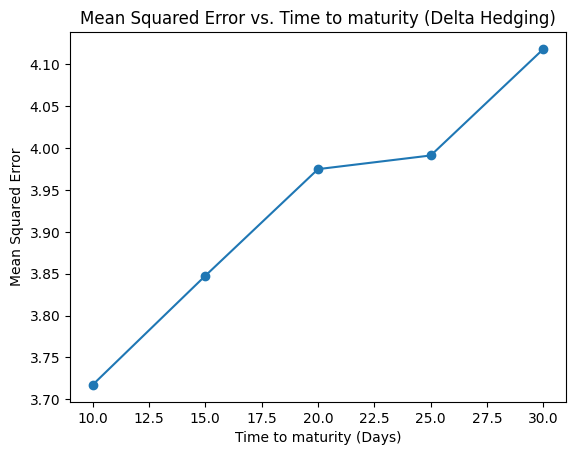

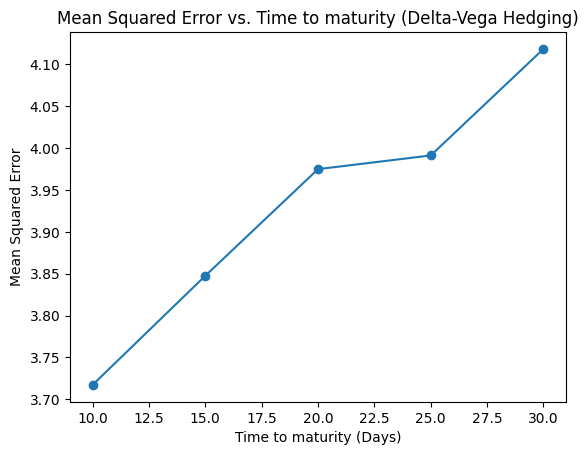

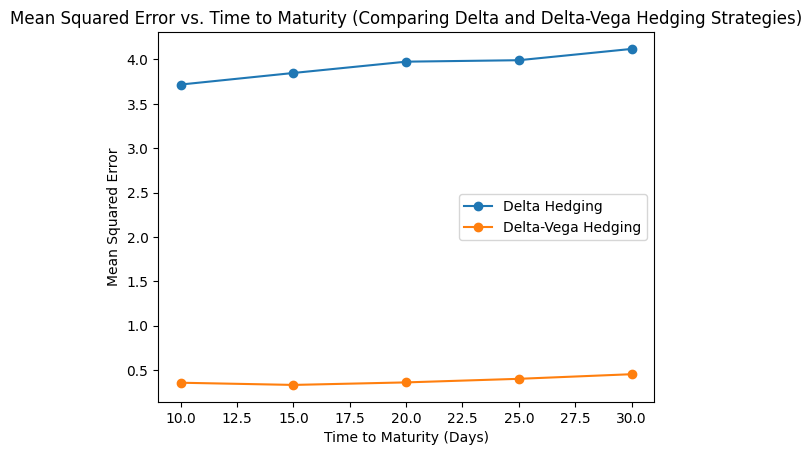

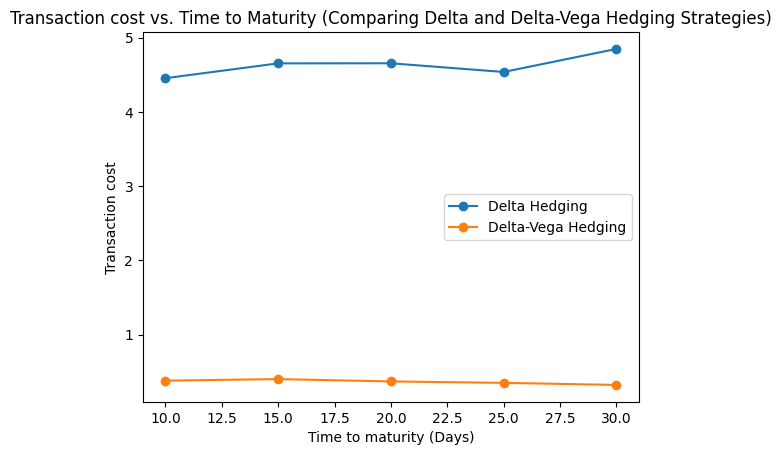

In [17]:
testing_multiple_time_to_maturity(data, oct_call_data, oct_put_data, nov_call_data)

In [24]:
# Impact of changing Strike prices on the accuracy of Delta Hedging 
# Fixed variables: Time to maturity = 45 days, Hedging every day

def testing_multiple_call_prices(all_options, call_options, put_options, sec1_call_data):
    mean_errors_delta_hedging = []
    mean_errors_delta_vega_hedging = []
    mean_transaction_cost_delta_hedging = []
    mean_transaction_cost_delta_vega_hedging = []
    expiration_date = '2023-10-20'
    start_date = all_options.at[all_options[all_options['Date'] == expiration_date].index[0] - 45, 'Date']
    atm_call_price = get_atm_call_price(start_date, call_options)
    strikes = [atm_call_price - 10, atm_call_price - 5, atm_call_price, atm_call_price + 5, atm_call_price + 10]

    for strike in strikes:        
        result_delta_hedging = option_portfolio_delta_hedging([['C'+str(int(strike)), 1, 'buy']], start_date, expiration_date, 1, all_options, call_options, put_options)
        mean_errors_delta_hedging.append(result_delta_hedging['mean_squered_error'])
        mean_transaction_cost_delta_hedging.append(result_delta_hedging['transaction_cost'])
        result_delta_vega_hedging = option_portfolio_delta_vega_hedging([['C'+str(int(strike)), 1, 'buy']], 'C'+str(int(strike)), start_date, expiration_date, 1, all_options, call_options, put_options, sec1_call_data)
        mean_errors_delta_vega_hedging.append(result_delta_vega_hedging['mean_squered_error'])
        mean_transaction_cost_delta_vega_hedging.append(result_delta_vega_hedging['transaction_cost'])

    # mean_errors_delta_hedging = (mean_errors_delta_hedging / 10.0)
    # mean_errors_delta_vega_hedging = (mean_errors_delta_vega_hedging / 10.0)
    # mean_transaction_cost_delta_hedging = (mean_transaction_cost_delta_hedging / 10.0)
    # mean_transaction_cost_delta_vega_hedging = (mean_transaction_cost_delta_vega_hedging / 10.0)

    legend = ['ATM - 10', 'ATM - 5', 'ATM', 'ATM + 5', 'ATM + 10']

    # Save data to files
    delta_performance_data = pd.DataFrame({'Call prices': legend, 'Mean Squared Error Delta Hedging': mean_errors_delta_hedging})
    delta_vega_performance_data = pd.DataFrame({'Call prices': legend, 'Mean Squared Error Delta-Vega Hedging': mean_errors_delta_vega_hedging})

    delta_performance_data.to_csv('delta_performance_multiple_call_prices.csv', index=False)
    delta_vega_performance_data.to_csv('delta_vega_performance_multiple_call_prices.csv', index=False)

    # Plotting
    plt.plot(legend, mean_errors_delta_hedging, marker='o')
    plt.xlabel('Call price')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Call price (Delta Hedging)')
    plt.show()

    plt.plot(legend, mean_errors_delta_vega_hedging, marker='o')
    plt.xlabel('Call price')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Call price (Delta-Vega Hedging)')
    plt.show()

    plt.plot(legend, mean_errors_delta_hedging, label='Delta Hedging', marker='o')
    plt.plot(legend, mean_errors_delta_vega_hedging, label='Delta-Vega Hedging', marker='o')
    plt.xlabel('Call price')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Call price (Comparing Delta and Delta-Vega Hedging Strategies)')
    plt.legend()
    plt.show()

    plt.plot(legend, mean_transaction_cost_delta_hedging, label='Delta Hedging', marker='o')
    plt.plot(legend, mean_transaction_cost_delta_vega_hedging, label='Delta-Vega Hedging', marker='o')
    plt.xlabel('Call price')
    plt.ylabel('Transaction cost')
    plt.title('Transaction cost vs. Call price (Comparing Delta and Delta-Vega Hedging Strategies)')
    plt.legend()
    plt.show()


3 missing data were detected during the delta hedging.
hedging_frequency
1
portfolio_values
[0.02022 0.01903 0.02239 0.02255 0.02651 0.021   0.02245 0.0222  0.02485
 0.02556 0.02415 0.02355 0.02813 0.0279  0.02566 0.0286  0.03104 0.02641
 0.02885 0.0316  0.02429 0.0217  0.02325 0.01615 0.0168  0.01355 0.013
 0.0104  0.0102  0.0104  0.0113  0.01524 0.01    0.0135  0.0132  0.0192
 0.02113 0.0195  0.0235  0.02171 0.01937 0.0231      nan 0.0204      nan
     nan]
portfolio_delta_values
[0.59211605 0.59069704 0.64232236 0.64906129 0.68226971 0.6252311
 0.65700565 0.66988268 0.72259858 0.72035256 0.71950268 0.74870142
 0.7787719  0.76758552 0.7407889  0.7870097  0.82952076 0.76938825
 0.8317064  0.83735675 0.77353116 0.80669675 0.75394501 0.68327479
 0.64785702 0.62911982 0.64837697 0.55171315 0.5648542  0.58176106
 0.62415822 0.73293808 0.57868602 0.6794227  0.69882152 0.82361527
 0.8665489  0.87264191 0.88876218 0.92267067 0.83981945 0.93473401
        nan 0.94769254        nan        nan]

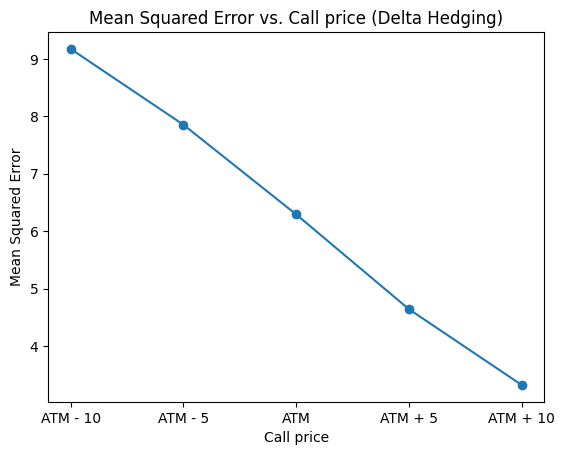

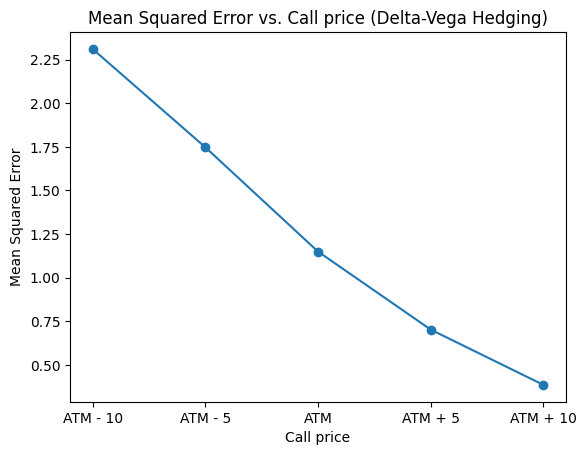

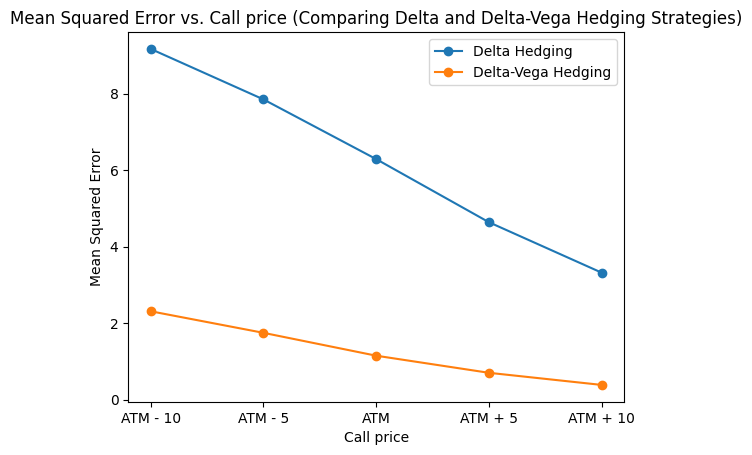

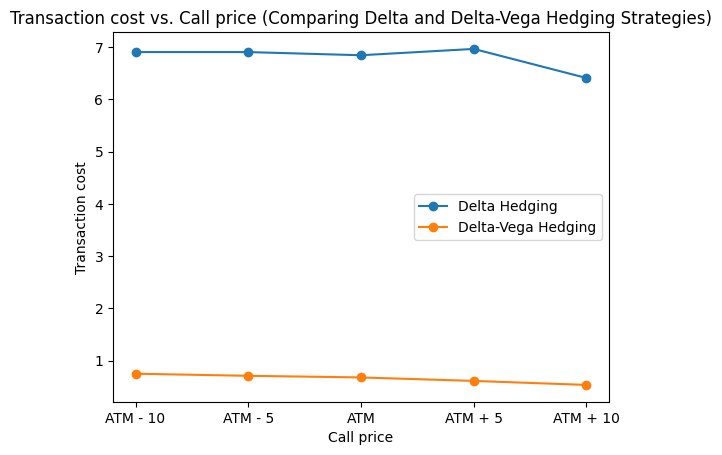

In [25]:
testing_multiple_call_prices(data, oct_call_data, oct_put_data, nov_call_data)

In [ ]:
start = pd.to_datetime('2023-09-15') 
end = pd.to_datetime('2023-10-19')

df = oct_call_data[pd.to_datetime(oct_call_data['Date']) >= start]
df = df[pd.to_datetime(df['Date']) <= end]
df = df[df['E'] == 0.33]
df.tail()


In [ ]:
results = option_portfolio_delta_vega_hedging([['C330', 1, 'buy']], 'C330', '2023-09-15', '2023-10-19', 1, data, oct_call_data, oct_put_data, nov_call_data)
print(results)